# TPCRP Algorithm Implementation

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader

# Feature Extraction

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)

100%|██████████| 170M/170M [00:10<00:00, 15.7MB/s] 


Use the pre-trained **ResNet18** model to extract feature embeddings.

In [3]:
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Identity()  # Remove final classification layer
model.eval()

def extract_features(data_loader, model):
    features = []
    with torch.no_grad():
        for images, _ in data_loader:
            output = model(images)
            features.append(output.numpy())
    return np.vstack(features)

features = extract_features(train_loader, model)

/home/mateo/ML-coursework2/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mateo/ML-coursework2/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# K-Means Clustering

In [4]:
num_clusters = 10  # Adjust based on budget
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(features)

# Selecting Typical Examples

In [5]:
def select_typical_examples(features, labels, num_per_cluster=1):
    selected_indices = []
    for cluster_id in range(num_clusters):
        cluster_indices = np.where(labels == cluster_id)[0]
        center = kmeans.cluster_centers_[cluster_id]
        distances = np.linalg.norm(features[cluster_indices] - center, axis=1)
        selected_indices.append(cluster_indices[np.argmin(distances)])  # Closest to centroid
    return selected_indices

selected_samples = select_typical_examples(features, labels)
print("Selected sample indices:", selected_samples)

Selected sample indices: [np.int64(10193), np.int64(31444), np.int64(48396), np.int64(26265), np.int64(5435), np.int64(36474), np.int64(6449), np.int64(14583), np.int64(20530), np.int64(49133)]


# Visualisation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..0.27058828].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.5921569].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.46666664..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7882353..1.0]

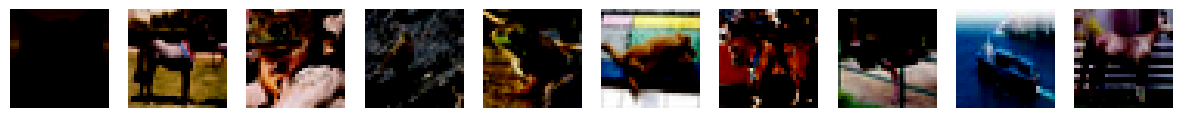

In [6]:
def show_images(dataset, indices):
    fig, axes = plt.subplots(1, len(indices), figsize=(15, 3))
    for ax, idx in zip(axes, indices):
        image, _ = dataset[idx]
        ax.imshow(np.transpose(image.numpy(), (1, 2, 0)))
        ax.axis('off')
    plt.show()

show_images(train_dataset, selected_samples)